In [521]:
import datetime 
import gc 

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

In [522]:
df = pd.read_csv('C:/Users/Frida/Downloads/realestatepriceprediction/train.csv')

In [523]:
#df['DistrictId'] = df['DistrictId'].astype('category')
#X_final['DistrictId'] = X_final['DistrictId'].astype('category')
df.set_index('Id', inplace=True)

In [524]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [525]:
class DataPipeline:
    def __init__(self):
        self.medians=None
    
    def fit(self, df):
        self.medians = df.median()
        
    def transform(self, df):
        
        #Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0,'Rooms'] = self.medians['Rooms']
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] 
        
        #KitchenSquare
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        df.loc[df['KitchenSquare'] > 40, 'KitchenSquare'] = self.medians['KitchenSquare'] 
        
        #Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['Floor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseYear']==0,'HouseFloor'] = self.medians['HouseFloor']
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']#домножить на 2
        
        #Year
        current_year = now = datetime.datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2005
        
        #Health
        if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        
        condition = (df['LifeSquare'].isna()) &\
                      (~df['Square'].isna()) & \
                      (~df['KitchenSquare'].isna())
        
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'] - 3
        
        df.loc[df['LifeSquare'] < 10, 'LifeSquare'] * 10
        df.loc[df['Square'] < 10, 'Square'] * 10
        df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df.loc[df['LifeSquare'] > df['Square'], 'Square']
    
        return df

In [526]:
imputer = DataPipeline()

imputer.fit(df)

df = imputer.transform(df)
#X_final = imputer.transform(X_final)

In [527]:
df.isnull().sum()

DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
LifeSquare_nan        0
dtype: int64

In [528]:
df['price_per_sqr'] = df['Price']/df['Square']

In [529]:
df.isnull().sum()

DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
LifeSquare_nan        0
price_per_sqr         0
dtype: int64

In [530]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,price_per_sqr
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,B,...,5,0,11,B,184966.930730,0,0,0,0,3854.958571
15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,B,...,1,1,16,B,300009.450063,0,0,0,0,4567.491245
4765,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,B,...,0,1,3,B,220925.908524,0,0,0,0,4915.149522
5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,B,...,3,0,5,B,175616.227217,0,0,0,0,3291.591637
10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,B,...,1,2,4,B,150226.531644,0,0,0,0,3788.892642


In [531]:
location_stats = df.groupby('DistrictId')['DistrictId'].agg('count').sort_values(ascending=False)
location_stats

DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
205      1
207      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [532]:
location_less_50 = location_stats[location_stats<=50]
location_less_50

DistrictId
111    49
119    49
0      48
78     46
91     44
       ..
199     1
117     1
205     1
207     1
209     1
Name: DistrictId, Length: 150, dtype: int64

In [533]:
df.DistrictId = df.DistrictId.apply(lambda x: 'other' if x in location_less_50 else x)

In [534]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,price_per_sqr
Id,,,,,,,,,,,,,,,,,,,,,
14038,other,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,B,...,5,0,11,B,184966.930730,0,0,0,0,3854.958571
15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,B,...,1,1,16,B,300009.450063,0,0,0,0,4567.491245
4765,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,B,...,0,1,3,B,220925.908524,0,0,0,0,4915.149522
5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,B,...,3,0,5,B,175616.227217,0,0,0,0,3291.591637
10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,B,...,1,2,4,B,150226.531644,0,0,0,0,3788.892642


In [535]:
df[df.LifeSquare/df.Rooms<13].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,price_per_sqr
Id,,,,,,,,,,,,,,,,,,,,,
4378,27,3.0,106.958871,0.641822,3.0,0.0,0.0,2018,0.072158,B,...,1,0,0,A,337299.867936,0,1,0,0,3153.547378
89,other,2.0,39.435351,23.377687,7.0,9.0,9.0,1965,0.007659,B,...,56,3,19,B,283877.617142,0,0,0,0,7198.556910
1853,101,3.0,58.419816,37.275614,5.0,5.0,5.0,1963,0.225825,A,...,7,3,2,B,197456.920814,0,0,0,0,3379.964810
3963,48,3.0,60.496736,38.701933,6.0,4.0,9.0,1980,0.041125,B,...,5,1,10,B,276349.912284,0,0,0,0,4568.013576
2435,85,4.0,65.559834,47.696255,6.0,6.0,9.0,1976,0.037178,B,...,1,1,7,B,266989.016142,0,0,0,0,4072.448011


In [536]:
df = df[~(df.LifeSquare/df.Rooms<13)]
df.shape

(9416, 23)

In [537]:
df.price_per_sqr.describe()

count     9416.000000
mean      3879.169968
std       1245.227316
min        208.293451
25%       2912.346403
50%       3894.849381
75%       4681.105741
max      11854.652892
Name: price_per_sqr, dtype: float64

In [538]:
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('DistrictId'):
        m = np.mean(subdf.price_per_sqr)
        st = np.std(subdf.price_per_sqr)
        reduced_df = subdf[(subdf.price_per_sqr>(m-st))&(subdf.price_per_sqr<=(m+st))]
        df_out = pd.concat([df_out, reduced_df],ignore_index=True)
    return df_out


In [539]:
df2 = remove_outliers(df)

In [540]:
df2.shape

(7200, 23)

In [541]:
df.shape

(9416, 23)

In [542]:
df['Rooms'].sort_values().unique()

array([1., 2., 3., 4., 5.])

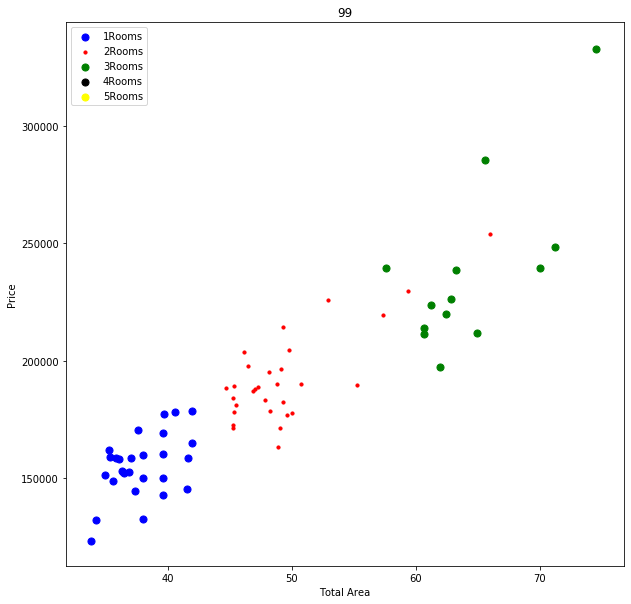

In [543]:
def plot_scatter_chart(df,DistrictId):
    rm1 = df[(df.DistrictId==DistrictId)&(df.Rooms==1)]
    rm2 = df[(df.DistrictId==DistrictId)&(df.Rooms==2.0)]
    rm3 = df[(df.DistrictId==DistrictId)&(df.Rooms==3.0)]
    rm4 = df[(df.DistrictId==DistrictId)&(df.Rooms==4)]
    rm5 = df[(df.DistrictId==DistrictId)&(df.Rooms==5)]
    plt.rcParams['figure.figsize'] = (10,10)
    plt.scatter(rm1.Square,rm1.Price,color='blue',label='1Rooms', s=50)
    plt.scatter(rm2.Square,rm2.Price,color='red',label='2Rooms', s=10)
    plt.scatter(rm3.Square,rm3.Price,color='green',label='3Rooms', s=50)
    plt.scatter(rm4.Square,rm4.Price,color='black',label='4Rooms', s=50)
    plt.scatter(rm5.Square,rm5.Price,color='yellow',label='5Rooms', s=50)
    plt.xlabel('Total Area')
    plt.ylabel('Price')
    plt.title(DistrictId)
    plt.legend()
    
plot_scatter_chart(df2,99)

In [544]:
def remove_rm(df):
    exclude_indices = np.array([])
    for DistrictId, DistrictId_df in df.groupby('DistrictId'):
        rooms_stats ={}
        for Rooms, Rooms_df in DistrictId_df.groupby('Rooms'):
            rooms_stats[Rooms] ={
                'mean' : np.mean(Rooms_df.price_per_sqr),
                'std' : np.std(Rooms_df.price_per_sqr),
                'count' : Rooms_df.shape[0]
            }
        for Rooms, Rooms_df in DistrictId_df.groupby('Rooms'):
            stats = rooms_stats.get(Rooms-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, Rooms_df[Rooms_df.price_per_sqr<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')    

In [545]:
df3 = remove_rm(df2)

In [546]:
df3.shape

(4450, 23)

In [547]:
df2.shape

(7200, 23)

In [548]:
df3.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,price_per_sqr
0,1,2.0,64.511437,58.511437,3.0,9.0,17.0,1977,0.007122,B,...,0,0,1,B,229102.795999,0,0,0,1,3551.351598
1,1,2.0,56.494318,54.723569,3.0,9.0,17.0,1977,0.007122,B,...,0,0,1,B,196078.907289,0,0,0,0,3470.772192


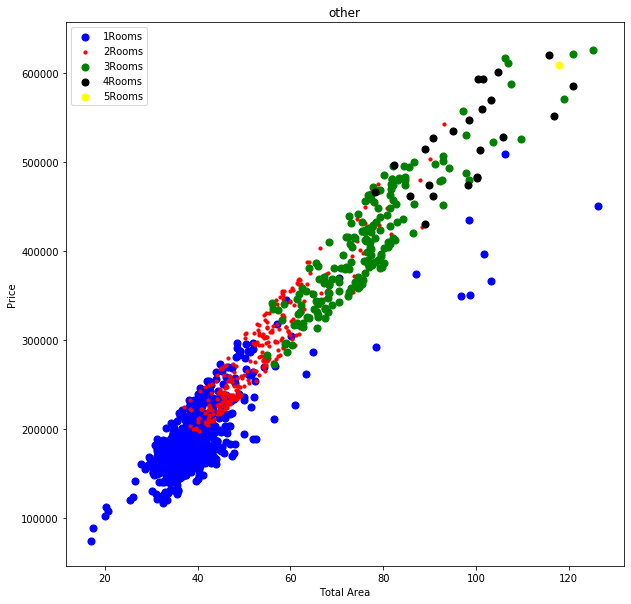

In [549]:
plot_scatter_chart(df3,'other')

In [550]:
df3['DistrictId'].value_counts()

other    1082
27        439
23        293
1         254
6         178
9         136
62        110
30         89
53         85
58         77
8          71
21         63
74         58
52         57
45         56
94         54
61         52
46         49
57         49
44         47
41         46
48         45
11         43
47         42
13         41
2          38
28         38
99         38
84         37
12         37
101        36
7          36
93         35
96         35
3          34
22         32
34         31
90         31
26         31
55         31
29         30
88         30
18         30
128        30
25         29
67         28
59         28
75         25
39         25
66         24
37         24
85         23
105        23
31         23
17         21
10         21
Name: DistrictId, dtype: int64

In [551]:
df4 = df3.drop(df3[df3.DistrictId=='other'].index)

In [552]:
df4['DistrictId'].value_counts()

27     439
23     293
1      254
6      178
9      136
62     110
30      89
53      85
58      77
8       71
21      63
74      58
52      57
45      56
94      54
61      52
46      49
57      49
44      47
41      46
48      45
11      43
47      42
13      41
99      38
28      38
2       38
84      37
12      37
101     36
7       36
96      35
93      35
3       34
22      32
55      31
26      31
34      31
90      31
18      30
128     30
88      30
29      30
25      29
67      28
59      28
39      25
75      25
37      24
66      24
85      23
31      23
105     23
17      21
10      21
Name: DistrictId, dtype: int64

In [553]:
df4['DistrictId'] = df4['DistrictId'].astype('category')

In [554]:
df4.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,price_per_sqr
0,1,2.0,64.511437,58.511437,3.0,9.0,17.0,1977,0.007122,B,...,0,0,1,B,229102.795999,0,0,0,1,3551.351598
1,1,2.0,56.494318,54.723569,3.0,9.0,17.0,1977,0.007122,B,...,0,0,1,B,196078.907289,0,0,0,0,3470.772192
3,1,1.0,42.414176,36.414176,3.0,14.0,17.0,1977,0.007122,B,...,0,0,1,B,156476.614348,0,0,0,1,3689.252712
5,1,1.0,50.617768,46.505676,3.0,10.0,24.0,1977,0.007122,B,...,0,0,1,B,175188.958216,0,0,0,0,3461.017023
7,1,2.0,55.233213,49.233213,3.0,13.0,17.0,1977,0.007122,B,...,0,0,1,B,184324.900886,0,0,0,1,3337.211266


In [555]:
df4['Shops_2'] = (df4['Shops_2'] == 'A').astype(int)
df4['Ecology_3'] = (df4['Ecology_3'] == 'A').astype(int)
df4['Ecology_2'] = (df4['Ecology_2'] == 'A').astype(int)

In [556]:
df4.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,price_per_sqr
0,1,2.0,64.511437,58.511437,3.0,9.0,17.0,1977,0.007122,0,...,0,0,1,0,229102.795999,0,0,0,1,3551.351598
1,1,2.0,56.494318,54.723569,3.0,9.0,17.0,1977,0.007122,0,...,0,0,1,0,196078.907289,0,0,0,0,3470.772192
3,1,1.0,42.414176,36.414176,3.0,14.0,17.0,1977,0.007122,0,...,0,0,1,0,156476.614348,0,0,0,1,3689.252712
5,1,1.0,50.617768,46.505676,3.0,10.0,24.0,1977,0.007122,0,...,0,0,1,0,175188.958216,0,0,0,0,3461.017023
7,1,2.0,55.233213,49.233213,3.0,13.0,17.0,1977,0.007122,0,...,0,0,1,0,184324.900886,0,0,0,1,3337.211266


In [574]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        #self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, df):
        district = df['DistrictId'].value_counts()
        self.DistrictId_counts = dict(district)
        df['DistrictId_popular'] = df['DistrictId'].copy()
        
        df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
        self.med_price_by_district = df.groupby(['DistrictId_popular'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

    def transform(self, df):
        # DistrictId
        df['DistrictId_count'] = df['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        df['new_district'] = 0
        df.loc[df['DistrictId_count'].isna(), 'new_district'] = 1
        
        df['DistrictId_count'].fillna(5, inplace=True)
        
        # Target encoding
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId'], how='left')
        
        return df

In [575]:
features = FeatureGenetator()

features.fit(df4)
df4 = features.transform(df4)

In [576]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3368 entries, 0 to 3367
Data columns (total 29 columns):
DistrictId              3368 non-null category
Rooms                   3368 non-null float64
Square                  3368 non-null float64
LifeSquare              3368 non-null float64
KitchenSquare           3368 non-null float64
Floor                   3368 non-null float64
HouseFloor              3368 non-null float64
HouseYear               3368 non-null float64
Ecology_1               3368 non-null float64
Ecology_2               3368 non-null float64
Ecology_3               3368 non-null float64
Social_1                3368 non-null float64
Social_2                3368 non-null float64
Social_3                3368 non-null float64
Helthcare_2             3368 non-null float64
Shops_1                 3368 non-null float64
Shops_2                 3368 non-null float64
Price                   3368 non-null float64
Rooms_outlier           3368 non-null float64
HouseFloor_outlier

In [577]:
X = df4.drop(['Price','price_per_sqr'], axis='columns')

In [578]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictId_popular,MedPriceByDistrict_x,DistrictId_count,new_district,MedPriceByDistrict_y,MedPriceByDistrict
0,1,2.0,64.511437,58.511437,3.0,9.0,17.0,1977.0,0.007122,0.0,...,0.0,0.0,0.0,1.0,1,156450.98275,254,0,156450.98275,156450.98275
1,1,2.0,56.494318,54.723569,3.0,9.0,17.0,1977.0,0.007122,0.0,...,0.0,0.0,0.0,0.0,1,156450.98275,254,0,156450.98275,156450.98275
2,1,1.0,42.414176,36.414176,3.0,14.0,17.0,1977.0,0.007122,0.0,...,0.0,0.0,0.0,1.0,1,156450.98275,254,0,156450.98275,156450.98275
3,1,1.0,50.617768,46.505676,3.0,10.0,24.0,1977.0,0.007122,0.0,...,0.0,0.0,0.0,0.0,1,156450.98275,254,0,156450.98275,156450.98275
4,1,2.0,55.233213,49.233213,3.0,13.0,17.0,1977.0,0.007122,0.0,...,0.0,0.0,0.0,1.0,1,156450.98275,254,0,156450.98275,156450.98275


In [579]:
y = df4.Price

In [580]:
y.head()

0    229102.795999
1    196078.907289
2    156476.614348
3    175188.958216
4    184324.900886
Name: Price, dtype: float64

In [581]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                   'LifeSquare_nan',
                   'HouseFloor', 'HouseYear', 'DistrictId_count', 'MedPriceByDistrict',]
target = 'Price'

In [582]:
df4 = df4[feature_names + [target]]

In [583]:
from sklearn.model_selection import train_test_split

In [591]:
X = df4[feature_names]
y = df4[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, shuffle=True, random_state=42)

In [595]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [596]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.931
RMSE:	21350.623
MSE:	455849107.044


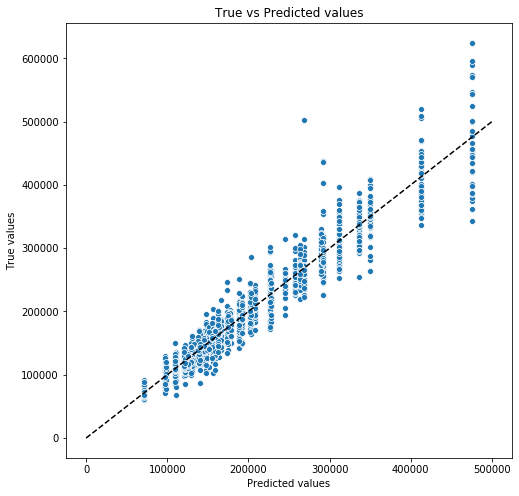

In [597]:
dt_model = DecisionTreeRegressor(criterion='mse',
                                 max_depth=20,
                                 min_samples_leaf=30,
                                 random_state=42)

dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.913
RMSE:	23828.001
MSE:	567773642.638


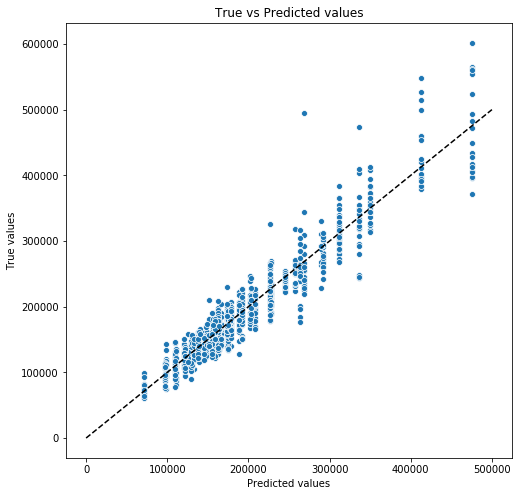

In [598]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [602]:
X_final = pd.read_csv('C:/Users/Frida/Downloads/realestatepriceprediction/test.csv')
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()
X_final.set_index('Id', inplace=True)
X_final['DistrictId'] = X_final['DistrictId'].astype('category')

In [603]:
X_final = imputer.transform(X_final)
X_final = features.transform(X_final)

In [605]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                   'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'MedPriceByDistrict']

X = X[remain_features]
X_final = X_final[remain_features]

In [606]:
model = LGBMRegressor(max_depth=10,
                             min_samples_leaf=10,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.965 +- 0.003


In [607]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

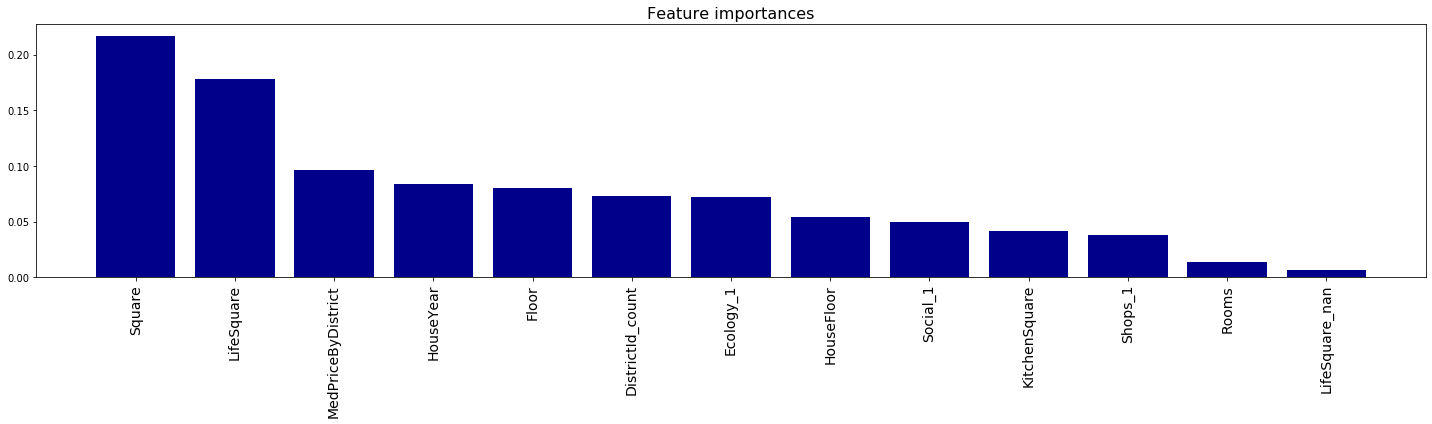

In [609]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [611]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('prediction.csv', index=False)

preds_final.head()

,Id,Price
0,725,167487.788077
1,15856,250101.982511
2,5480,84022.038383
3,15664,337398.036869
4,14275,144093.114405
